# Rules Based ChatBot : "AirBOT" from Lallemand Flavien & Deffontaines Germain

In [181]:
# install the diffetents libraries

In [182]:
!pip install stop_words

In [183]:
!pip install wordcloud

In [184]:
!pip install gensim

In [185]:
! pip install pyLDAvis

In [186]:
#import all libraries that we need

import pandas as pd
import contractions
import re
import nltk
import string
from nltk.tokenize import  word_tokenize
import numpy as np
from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import gensim.corpora as corpora
from pprint import pprint
import gensim
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import random


In [187]:
# load the Q&A csv
df = pd.read_csv('question_responce.csv')	

In [188]:
# quick look of the csv
df.head()

,Unnamed: 0,responce,question
0,603,@115904 We'll be sure to pass along your kind ...,@AmericanAir Erica on the lax team is amazing ...
1,605,@115904 Our apologies for the delay in respond...,@AmericanAir Could you have someone on your la...
2,608,"@115905 Aww, that's definitely a future pilot ...",Ben Tennyson and an American Airlines pilot. 🎃...
3,612,@115906 We're sorry for your frustration.,"@AmericanAir Right, but I earned those. I also..."
4,618,@115909 We're glad you got to kick back and en...,"Thank you, @AmericanAir for playing #ThisIsUs ..."


## Preprocessing of the csv

In [189]:
#preprocessing functions


def remove_punctuation(word_list):
    PUNCUATION_LIST = list(string.punctuation)
    return [w for w in word_list if w not in PUNCUATION_LIST]


def preproc_pipe(data):
    
    data = data.dropna()
    data_clean = pd.DataFrame()
    data_clean['text'] = data
    
    #text to lowercase
    data_clean['text'] = data_clean['text'].str.lower()

    #remove URL links
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
    data_clean['text'].apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))

    #remove placeholders
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r'{link}', '', x))
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r"\[video\]", '', x))

    #remove HTML reference characters
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r'&[a-z]+;', '', x))

    #remove handles
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r"@([a-zA-Z0-9_]{1,50})","", x))

    #remove non-letter characters
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x))

    # Replace contractions with their longer forms 
    data_clean['text'] = data_clean['text'].apply(lambda x:  contractions.fix(x))



    #tokenize
    data_clean['tokens'] = data_clean['text'].apply(nltk.word_tokenize)

    #remove punctuation
    data_clean['tokens'] = data_clean['tokens'].apply(remove_punctuation)


    #remove stopwords
    stop_words = list(get_stop_words('en'))         #About 900 stopwords
    nltk_words = list(stopwords.words('english')) #About 150 stopwords
    stop_words.extend(nltk_words)

    data_clean['tokens'] = data_clean['tokens'].apply(lambda x: [w for w in x if w not in stop_words])

    #stemming/lemmatization

      
    lemmatizer = WordNetLemmatizer()
    data_clean['tokens'] = data_clean['tokens'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

    #remove non english word
    return data_clean



In [190]:
# call of the preprocess/tokenize function
df[['responce_clean','token_responce']] = preproc_pipe(df['responce'])
df[['question_clean','token_question']] = preproc_pipe(df['question'])

In [191]:
#Quick look of the dataframe
df.head()

,Unnamed: 0,responce,question,responce_clean,token_responce,question_clean,token_question
0,603,@115904 We'll be sure to pass along your kind ...,@AmericanAir Erica on the lax team is amazing ...,we will be sure to pass along your kind words...,"[sure, pas, along, kind, word, aateam]",erica on the lax team is amazing give her a r...,"[erica, lax, team, amazing, give, raise, ty]"
1,605,@115904 Our apologies for the delay in respond...,@AmericanAir Could you have someone on your la...,our apologies for the delay in responding to ...,"[apology, delay, responding, made, lax, let, u...",could you have someone on your lax team avail...,"[someone, lax, team, available, guide, gate, s..."
2,608,"@115905 Aww, that's definitely a future pilot ...",Ben Tennyson and an American Airlines pilot. 🎃...,aww that is definitely a future pilot in the ...,"[aww, definitely, future, pilot, making, happy...",ben tennyson and an american airlines pilot #...,"[ben, tennyson, american, airline, pilot, trun..."
3,612,@115906 We're sorry for your frustration.,"@AmericanAir Right, but I earned those. I also...",we are sorry for your frustration,"[sorry, frustration]",right but i earned those i also should not ha...,"[right, earned, also, pay, pas, spouse, need, ..."
4,618,@115909 We're glad you got to kick back and en...,"Thank you, @AmericanAir for playing #ThisIsUs ...",we are glad you got to kick back and enjoy a ...,"[glad, got, kick, back, enjoy, show, flying, t...",thank you for playing #thisisus and for havin...,"[thank, playing, thisisus, great, flight, atte..."


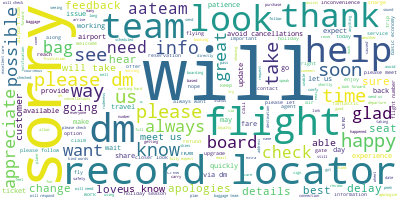

In [192]:
# Visualise word cloud to have a quick look of the differents vocans terms for the responces part

long_string = ','.join(list(df['responce_clean'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

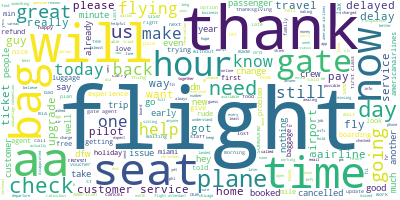

In [193]:
# Visualise word cloud to have a quick look of the differents vocans terms for the questions part

long_string = ','.join(list(df['question_clean'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

## TOPIC MODELING LDA

In [ ]:
#creation of the dictonary of topics
data_words = df['token_question']
id2word = corpora.Dictionary(data_words)# Create Corpus

In [195]:
texts = data_words# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [196]:

num_topics = 20# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"flight" + 0.011*"thanks" + 0.011*"back" + 0.009*"customer" + '
  '0.009*"please" + 0.008*"need" + 0.008*"plane" + 0.008*"service" + '
  '0.008*"help" + 0.007*"check"'),
 (1,
  '0.039*"flight" + 0.011*"day" + 0.010*"year" + 0.009*"first" + 0.007*"still" '
  '+ 0.007*"airline" + 0.006*"today" + 0.006*"aa" + 0.006*"even" + '
  '0.006*"cancelled"'),
 (2,
  '0.041*"flight" + 0.014*"plane" + 0.011*"hour" + 0.010*"today" + 0.009*"bag" '
  '+ 0.008*"upgrade" + 0.008*"get" + 0.007*"first" + 0.007*"gate" + '
  '0.006*"time"'),
 (3,
  '0.026*"flight" + 0.009*"bag" + 0.008*"hey" + 0.008*"gate" + 0.008*"time" + '
  '0.008*"get" + 0.008*"passenger" + 0.007*"say" + 0.007*"aa" + '
  '0.007*"customer"'),
 (4,
  '0.023*"flight" + 0.019*"bag" + 0.013*"get" + 0.009*"u" + 0.008*"another" + '
  '0.008*"thank" + 0.007*"like" + 0.007*"way" + 0.007*"time" + 0.007*"one"'),
 (5,
  '0.040*"flight" + 0.017*"get" + 0.011*"great" + 0.010*"gate" + '
  '0.009*"thanks" + 0.008*"aa" + 0.008*"bag" + 0.008*

In [197]:
# add a "topic" column to the dataframe

df['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(df))]

In [198]:
# see witch topic has the more questions

df.topic.value_counts()

0     326
5     133
14    110
2     108
10    105
8     104
1      86
3      84
4      80
17     79
19     77
6      73
13     72
12     72
9      69
16     68
7      65
11     59
15     48
18     34
Name: topic, dtype: int64

In [199]:
# Quick look

df.head()

,Unnamed: 0,responce,question,responce_clean,token_responce,question_clean,token_question,topic
0,603,@115904 We'll be sure to pass along your kind ...,@AmericanAir Erica on the lax team is amazing ...,we will be sure to pass along your kind words...,"[sure, pas, along, kind, word, aateam]",erica on the lax team is amazing give her a r...,"[erica, lax, team, amazing, give, raise, ty]",8
1,605,@115904 Our apologies for the delay in respond...,@AmericanAir Could you have someone on your la...,our apologies for the delay in responding to ...,"[apology, delay, responding, made, lax, let, u...",could you have someone on your lax team avail...,"[someone, lax, team, available, guide, gate, s...",19
2,608,"@115905 Aww, that's definitely a future pilot ...",Ben Tennyson and an American Airlines pilot. 🎃...,aww that is definitely a future pilot in the ...,"[aww, definitely, future, pilot, making, happy...",ben tennyson and an american airlines pilot #...,"[ben, tennyson, american, airline, pilot, trun...",10
3,612,@115906 We're sorry for your frustration.,"@AmericanAir Right, but I earned those. I also...",we are sorry for your frustration,"[sorry, frustration]",right but i earned those i also should not ha...,"[right, earned, also, pay, pas, spouse, need, ...",9
4,618,@115909 We're glad you got to kick back and en...,"Thank you, @AmericanAir for playing #ThisIsUs ...",we are glad you got to kick back and enjoy a ...,"[glad, got, kick, back, enjoy, show, flying, t...",thank you for playing #thisisus and for havin...,"[thank, playing, thisisus, great, flight, atte...",5


In [200]:
# Visualize the differents topics

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/home/germain/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of 

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.060057 -0.006921       1        1  7.716081
14    -0.047423 -0.035750       2        1  7.461306
8     -0.046428 -0.019458       3        1  6.384291
10    -0.040209  0.067962       4        1  6.259871
2     -0.044183 -0.025457       5        1  6.030650
17    -0.028346 -0.058670       6        1  5.420296
3     -0.016761 -0.032946       7        1  5.229815
19     0.033769  0.081383       8        1  4.965148
13    -0.004871 -0.006281       9        1  4.935142
1     -0.050576  0.043363      10        1  4.897373
12    -0.016570  0.017264      11        1  4.837206
4     -0.002201  0.038418      12        1  4.658818
6     -0.009861  0.031062      13        1  4.482331
16     0.036627 -0.062512      14        1  4.455146
9      0.028173 -0.103784      15        1  4.454342
7     -0.013414  0.028228      16        1  4.300480
0     -0.033230 -0.025679      17        1  4.017951
11     0.134560 -0.054817      18        1  3.726199
15     0.033431  0.085877      19        1  3.330236
18     0.147570  0.038718      20        1  2.437318, topic_info=         Term        Freq       Total Category  logprob  loglift
33     flight  522.000000  522.000000  Default  30.0000  30.0000
142      seat  111.000000  111.000000  Default  29.0000  29.0000
249       bag  113.000000  113.000000  Default  28.0000  28.0000
75     ticket   55.000000   55.000000  Default  27.0000  27.0000
170  customer   95.000000   95.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
27        pay    1.494228   38.202876  Topic20  -5.7161   0.4730
512      call    1.494187   21.190076  Topic20  -5.7161   1.0623
327      love    1.494169   26.098952  Topic20  -5.7161   0.8539
152   waiting    1.494148   31.187660  Topic20  -5.7162   0.6758
45       look    1.494139   24.534844  Topic20  -5.7162   0.9157

[1547 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
39        2  0.167649       's
39        3  0.125737       's
39        4  0.167649       's
39        6  0.041912       's
39        7  0.041912       's
...     ...       ...      ...
742       9  0.175983     york
742      14  0.175983     york
742      15  0.351966     york
4090      7  0.605135  yousuck
3283      8  0.621507    youth

[4469 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 15, 9, 11, 3, 18, 4, 20, 14, 2, 13, 5, 7, 17, 10, 8, 1, 12, 16, 19])

In [201]:
# Show the perplexity (the less is the better)

print('Perplexity: ', lda_model.log_perplexity(corpus))  

Perplexity:  -8.463106856720483


## VECTORIZE

In [202]:
# We just need to run this code once, the function glove2word2vec saves the Glove embeddings in the word2vec format 
# that will be loaded in the next section

#glove2word2vec('/home/germain/Documents/Rule_Based_ChatBot/glove.twitter.27B.100d.txt', 'glove.twitter.27B.100d.word2vec')

In [203]:
# load the Stanford GloVe model
model = KeyedVectors.load_word2vec_format('glove.twitter.27B.100d.word2vec', binary=False)

In [204]:
#vectorize function with our model

def vectorize(tokenized_sentence):
    result = []
    for token in tokenized_sentence:
        if(token in model.key_to_index):
            result.append(model[token])
    return np.mean(result, axis=0)



# vectorize the questions and responce part

df['responce_vect'] = df['token_responce'].apply(vectorize)
df['question_vect'] = df['token_question'].apply(vectorize)

In [205]:
# Quick look at our dataframe

df.head()

,Unnamed: 0,responce,question,responce_clean,token_responce,question_clean,token_question,topic
0,603,@115904 We'll be sure to pass along your kind ...,@AmericanAir Erica on the lax team is amazing ...,we will be sure to pass along your kind words...,"[sure, pas, along, kind, word, aateam]",erica on the lax team is amazing give her a r...,"[erica, lax, team, amazing, give, raise, ty]",8
1,605,@115904 Our apologies for the delay in respond...,@AmericanAir Could you have someone on your la...,our apologies for the delay in responding to ...,"[apology, delay, responding, made, lax, let, u...",could you have someone on your lax team avail...,"[someone, lax, team, available, guide, gate, s...",19
2,608,"@115905 Aww, that's definitely a future pilot ...",Ben Tennyson and an American Airlines pilot. 🎃...,aww that is definitely a future pilot in the ...,"[aww, definitely, future, pilot, making, happy...",ben tennyson and an american airlines pilot #...,"[ben, tennyson, american, airline, pilot, trun...",10
3,612,@115906 We're sorry for your frustration.,"@AmericanAir Right, but I earned those. I also...",we are sorry for your frustration,"[sorry, frustration]",right but i earned those i also should not ha...,"[right, earned, also, pay, pas, spouse, need, ...",9
4,618,@115909 We're glad you got to kick back and en...,"Thank you, @AmericanAir for playing #ThisIsUs ...",we are glad you got to kick back and enjoy a ...,"[glad, got, kick, back, enjoy, show, flying, t...",thank you for playing #thisisus and for havin...,"[thank, playing, thisisus, great, flight, atte...",5


# AirBOT functions
So we've made preprocessing,find topics, so we just have to make the chatbot.

In [206]:
# drop the empty lines

df = df.dropna()

In [207]:
type(int([sorted(lda_model[corpus][text])[0][0] for text in range(len(df))][:1][0]))

int

In [208]:


def reponse (sentence):
    #put sentence to a dataframe
    d = {'text': [sentence]}
    phrase = pd.DataFrame(data=d)
    phrase[['text_clean','text_token']] = preproc_pipe(phrase)

    #and vectorized it
    phrase['vectorized'] = phrase['text_token'].apply(vectorize)

    #find the topic
    
    #creation of the dictonary of topics
    datafr = df['token_question']
    datafr = pd.concat([datafr,phrase['text_token']])
    data_words = datafr
    id2word = corpora.Dictionary(data_words)# Create Corpus
  

    texts = data_words# Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]# View
   

    num_topics = 20# Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics)# Print the Keyword in the 10 topics

    # add a "topic" column to the dataframe

    df['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(df))]
    topic = int([sorted(lda_model[corpus][text])[0][0] for text in range(len(df))][:1][0])
    dftop = df.mask(df['topic'] == topic)
    dftop.dropna()
    


    df['vectoriz'] = df['token_question'][df['topic'] == topic].apply(vectorize)
    datafina = df.dropna().copy()
    compt = 0
    cosi = []
    for i in datafina.index:
        cosi.append(float(cosine_similarity(phrase['vectorized'][0].reshape(1, -1),datafina['vectoriz'][i].reshape(1, -1))))
        compt +=1
    datafina.loc[:,['cosine']] = cosi

    return datafina[['responce_clean','question','cosine']].nlargest(1, ['cosine'])['responce_clean'].values[0]



In [216]:
def bot():
    flag=True

    while(flag==True):
        user_response = input()
        print("You : "+user_response)
        user_response=user_response.lower()
        if(user_response!='bye'):

            if((greeting(user_response)!=None)):
                
                print("AirBOT: "+greeting(user_response))
            elif((goodbye(user_response)!=None)):
                print("AirBOT: "+goodbye(user_response))
            elif((apologies(user_response)!=None)):
                print("AirBOT: "+apologies(user_response))
            elif ((thanks(user_response)!=None)):
                print("AirBOT: "+thanks(user_response))
            else:
                
                print("AirBOT:"+reponse(user_response))
                    
        else:
            flag=False
            
            print("AirBOT: Bye! take care..")

#### Greeting

In [217]:

GREETING_INPUTS = ("hello", "hi", "greetings", "sup", "what's up","hey",)
GREETING_RESPONSES = ["hi", "hey", "*nods*", "hi there", "hello", "I am glad! You are talking to me"]
def greeting(sentence):
    for word in sentence.split():
        if word.lower() in GREETING_INPUTS:
            return random.choice(GREETING_RESPONSES)

#### Goodbye

In [218]:
GOODBYE_INPUTS = ("bye", "goodbye", "see you later", "cya")
GOODBYE_RESPONSES = ["see you later", "goodbye", "see you", "cya","have a nice day"]
def goodbye(sentence):
 
    for word in sentence.split():
        if word.lower() in GOODBYE_INPUTS:
            return random.choice(GOODBYE_RESPONSES)

#### Apology

In [219]:
APOLOGIES_INPUTS = ("sorry","my bad","mb","my fault")
APOLOGIES_RESPONSES = ["It's alright, I know.","don't worry about it.","no problem","no worries"]
def apologies(sentence):
     
        for word in sentence.split():
            if word.lower() in APOLOGIES_INPUTS:
                return random.choice(APOLOGIES_RESPONSES)

#### Thanks

In [220]:
THANKS_INPUTS = ("thanks","thank you","thank","thx","thnx",)
THANKS_RESPONSES = ["You're welcome","No problem","My pleasure","My pleasure","My pleasure"]
def thanks(sentence):
         
            for word in sentence.split():
                if word.lower() in THANKS_INPUTS:
                    return random.choice(THANKS_RESPONSES)

In [221]:
def main():
    print("AirBOT: My name is AirBOT. I will answer your queries about our flights. If you want to exit, type Bye!")
    bot()


In [222]:
main()

AirBOT: My name is AirBOT. I will answer your queries about our flights. If you want to exit, type Bye!
You : thanks
AirBOT: You're welcome
You : mb
AirBOT: no worries
You : hello
AirBOT: hello
You : goodbye
AirBOT: see you
You : i have an issue
AirBOT: thanks for providing feedback on this we are always working towards improved experiences for our customers
You : bye
AirBOT: Bye! take care..
